In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
DATASET_PATH = "data"
classes = ["dog", "cat", "bird"]

def load_mel_spectrogram(file_path, n_mels=128, max_len=128):
    y, sr = librosa.load(file_path, sr=None)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Resize to fixed dimension
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0,0),(0,pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]

    return mel_db

In [4]:
X = []
y = []

for label in classes:
    folder = os.path.join("../data", label)
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)

        mel = load_mel_spectrogram(file_path)
        mel = np.expand_dims(mel, axis=-1)  # shape (128,128,1)

        X.append(mel)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [5]:
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)

X_train, X_val, y_train_int, y_val_int = train_test_split(
    X, y_int, test_size=0.2, random_state=42, stratify=y_int
)

In [6]:
class PatchLayer(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, [tf.shape(images)[0], -1, patch_dim])
        return patches

In [7]:
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch_inputs):
        positions = tf.range(start=0, limit=tf.shape(patch_inputs)[1])
        return self.projection(patch_inputs) + self.position_embedding(positions)

In [8]:
def transformer_encoder(x, num_heads, ff_dim, dropout=0.1):

    # Multi-head self-attention
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    attn = layers.Dropout(dropout)(attn)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn)

    # Feed-forward
    ffn = layers.Dense(ff_dim, activation="relu")(out1)
    ffn = layers.Dense(x.shape[-1])(ffn)
    ffn = layers.Dropout(dropout)(ffn)

    return layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)

In [9]:
def build_vit_classifier(
    input_shape=(128, 128, 1),
    patch_size=16,
    projection_dim=64,
    transformer_layers=4,
    num_heads=4,
    ff_dim=128,
    num_classes=3,
):

    inputs = layers.Input(shape=input_shape)

    # 1. Create patches
    patches = PatchLayer(patch_size)(inputs)

    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

    # 2. Embed patches
    embeddings = PatchEmbedding(num_patches, projection_dim)(patches)

    # 3. Transformer encoder stack
    x = embeddings
    for _ in range(transformer_layers):
        x = transformer_encoder(x, num_heads, ff_dim)

    # 4. Classification head (CLS-like pooling)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

In [10]:
model_vit = build_vit_classifier(
    input_shape=(128, 128, 1),
    num_classes=len(classes)
)

model_vit.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_vit.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_layer         │ (None, None, 256) │          0 │ input_layer[0][0] │
│ (PatchLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, None, 64)  │     20,544 │ patch_layer[0][0] │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ patch_embedding[… │
│ (MultiHeadAttentio… │                   │            │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 64)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ patch_embedding[… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 64)  │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 64)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, None, 64)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None, 64)  │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, None, 64)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 618,755 (2.36 MB)

 Trainable params: 618,755 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model_vit.fit(
    X_train, y_train_int,
    validation_data=(X_val, y_val_int),
    epochs=20,
    batch_size=32
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.3258 - loss: 1.1579 - val_accuracy: 0.3607 - val_loss: 1.1039
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.3689 - loss: 1.1109 - val_accuracy: 0.4098 - val_loss: 1.1087
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.3279 - loss: 1.1372 - val_accuracy: 0.3525 - val_loss: 1.0945
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.3361 - loss: 1.1200 - val_accuracy: 0.3443 - val_loss: 1.1030
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.3340 - loss: 1.1336 - val_accuracy: 0.3443 - val_loss: 1.1057
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.3484 - loss: 1.1215 - val_accuracy: 0.3443 - val_loss: 1.1003
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.3135 - loss: 1.1348 - val_accuracy: 0.3689 - val_loss: 1.0943
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.3525 - loss: 1.1224 - val_accuracy: 0.

In [18]:
# Get final train and validation accuracy
final_train_acc = history.history['accuracy'][-1] * 100

print(f"Accuracy: {final_train_acc:.2f}%")

Accuracy: 34.63%


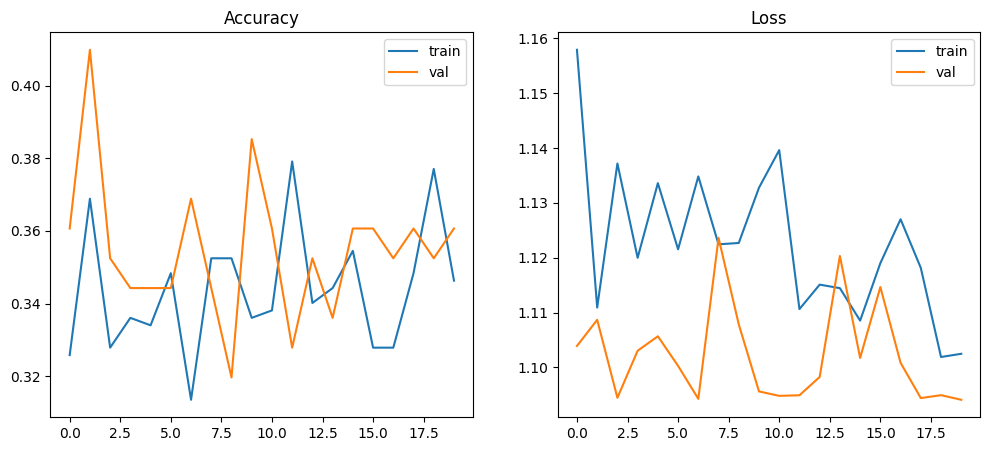

In [16]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["train", "val"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(["train", "val"])

plt.show()